In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from dbscan_cluster import run_dbscan
from cluster_utils import cluster_plot, cluster_plot_galactic
import json

from astropy.coordinates import SkyCoord, ICRS
import astropy.units as u
from simbad_download import resolve_name
from uncertainties import unumpy, ufloat
from sklearn.preprocessing import StandardScaler

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
CLUSTER_NAME: str = 'Trumpler 5'

In [3]:
gaiadr3 = pd.read_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}.csv')
normalized = np.loadtxt(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_normalized.dat')
uncert = np.loadtxt(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_normalized_uncert.dat')
normalized_cp = np.loadtxt(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_normalized_cp.dat')
uncert_cp = np.loadtxt(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_normalized_cp_uncert.dat')
lit = pd.read_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_literature.csv')

In [4]:
lit_dr3 = pd.merge(left=lit[['EDR3 id', 'reported', 'TIC']], right=gaiadr3, left_on='EDR3 id', right_on='source_id', how='inner')

In [5]:
cp_ra, cp_dec, cp_par, cp_pmra, cp_pmdec, cp_radvel = resolve_name(CLUSTER_NAME)

In [6]:
galactic_coords = SkyCoord(ra=cp_ra*u.deg, dec=cp_dec*u.deg,
                           pm_ra_cosdec=cp_pmra*u.mas/u.year, frame=ICRS,
                           pm_dec=cp_pmdec*u.mas/u.year).galactic

In [7]:
galactic_coords

<SkyCoord (Galactic): (l, b) in deg
    (202.81430932, 1.02114113)
 (pm_l_cosb, pm_b) in mas / yr
    (-0.51352324, -0.39865133)>

# Plain DBSCAN

In [8]:
clustered, noise, found, not_found = run_dbscan(normalized, gaiadr3, lit_dr3, 0.15, 2, False)

Classified into 1039 labels.
Clustered: 593/815
593/815 sources from literature clustered
1910 clustered sources.


In [9]:
clustered_sets = []
noise_sets = []
found_sets = []
not_found_sets = []

for _ in range(50):
    normalized_u = normalized + np.random.normal(scale=np.abs(uncert), size=normalized.shape)
    clustered, noise, found, not_found = run_dbscan(normalized_u, gaiadr3, lit_dr3, 0.175, 2, False)
    clustered_sets.append(clustered)
    noise_sets.append(noise)
    found_sets.append(found)
    not_found_sets.append(not_found)

Classified into 798 labels.
Clustered: 528/815
528/815 sources from literature clustered
1264 clustered sources.
Classified into 838 labels.
Clustered: 515/815
515/815 sources from literature clustered
1194 clustered sources.
Classified into 819 labels.
Clustered: 538/815
538/815 sources from literature clustered
1262 clustered sources.
Classified into 824 labels.
Clustered: 533/815
533/815 sources from literature clustered
1288 clustered sources.
Classified into 822 labels.
Clustered: 545/815
545/815 sources from literature clustered
1292 clustered sources.
Classified into 820 labels.
Clustered: 542/815
542/815 sources from literature clustered
1286 clustered sources.
Classified into 848 labels.
Clustered: 526/815
526/815 sources from literature clustered
1293 clustered sources.
Classified into 827 labels.
Clustered: 531/815
531/815 sources from literature clustered
1298 clustered sources.
Classified into 799 labels.
Clustered: 547/815
547/815 sources from literature clustered
1336 cl

In [10]:
clustered = pd.concat(clustered_sets).drop_duplicates(subset=['source_id'])
len(clustered)

3595

In [11]:
found = pd.concat(found_sets).drop_duplicates(subset=['source_id'])
len(found)

790

In [12]:
not_found = pd.concat(not_found_sets).drop_duplicates(subset=['source_id'])
len(not_found)

698

In [13]:
clustered.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,A_y,A_J,A_H,A_K,BP-RP,BP-RP_error,G_abs,G_abs_error,excess,label
504,1636148068921376768,Gaia DR3 3326759278094068096,3326759278094068096,144644199,2016.0,99.035023,0.083423,9.197648,0.074498,0.356305,...,1.831632,1.149592,0.680155,0.438838,0.679724,0.015757,3.778387,0.557947,0.059615,22
556,1636148068921376768,Gaia DR3 3326759896569333760,3326759896569333760,895259252,2016.0,99.180149,0.075414,9.183248,0.067116,0.266275,...,2.310027,1.449848,0.857801,0.553455,0.603479,0.01222,2.733251,0.702601,0.067272,22
557,1636148068921376768,Gaia DR3 3326759900867936128,3326759900867936128,470819439,2016.0,99.191946,0.091877,9.187837,0.08534,0.305167,...,2.280153,1.431099,0.846708,0.546298,0.711428,0.023329,3.591421,0.764209,0.058557,22
619,1636148068921376768,Gaia DR3 3326760519343280640,3326760519343280640,361350835,2016.0,99.083586,0.074643,9.192592,0.068514,0.287048,...,2.062652,1.294588,0.765941,0.494187,0.490513,0.015082,3.093387,0.612439,0.083859,22
661,1636148068921376768,Gaia DR3 3326760966019844480,3326760966019844480,243075725,2016.0,99.093215,0.055145,9.243582,0.049686,0.250329,...,2.648905,1.662539,0.983639,0.634647,0.506112,0.00795,1.958441,0.534605,0.09056,22


In [14]:
occurences = clustered['source_id'].apply(lambda x:
                                          sum([len(np.intersect1d(cs.source_id.values, [x])) for cs in clustered_sets]))

In [15]:
found['occurences'] = found['source_id'].apply(lambda x:
                                          sum([len(np.intersect1d(cs.source_id.values, [x])) for cs in found_sets]))/50.0

In [16]:
not_found['occurences'] = 1.0-not_found['source_id'].apply(lambda x:
                                                       sum([len(np.intersect1d(cs.source_id.values, [x])) for cs in not_found_sets]))/50.0

In [17]:
clustered['occurences'] = occurences/50.0
clustered.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,A_J,A_H,A_K,BP-RP,BP-RP_error,G_abs,G_abs_error,excess,label,occurences
504,1636148068921376768,Gaia DR3 3326759278094068096,3326759278094068096,144644199,2016.0,99.035023,0.083423,9.197648,0.074498,0.356305,...,1.149592,0.680155,0.438838,0.679724,0.015757,3.778387,0.557947,0.059615,22,0.12
556,1636148068921376768,Gaia DR3 3326759896569333760,3326759896569333760,895259252,2016.0,99.180149,0.075414,9.183248,0.067116,0.266275,...,1.449848,0.857801,0.553455,0.603479,0.01222,2.733251,0.702601,0.067272,22,0.22
557,1636148068921376768,Gaia DR3 3326759900867936128,3326759900867936128,470819439,2016.0,99.191946,0.091877,9.187837,0.08534,0.305167,...,1.431099,0.846708,0.546298,0.711428,0.023329,3.591421,0.764209,0.058557,22,0.04
619,1636148068921376768,Gaia DR3 3326760519343280640,3326760519343280640,361350835,2016.0,99.083586,0.074643,9.192592,0.068514,0.287048,...,1.294588,0.765941,0.494187,0.490513,0.015082,3.093387,0.612439,0.083859,22,0.16
661,1636148068921376768,Gaia DR3 3326760966019844480,3326760966019844480,243075725,2016.0,99.093215,0.055145,9.243582,0.049686,0.250329,...,1.662539,0.983639,0.634647,0.506112,0.00795,1.958441,0.534605,0.09056,22,0.30


In [18]:
cp_coords = SkyCoord(ra=cp_ra*u.deg, dec=cp_dec*u.deg, frame=ICRS)
cp_ra = cp_coords.ra.wrap_at(180*u.deg).value

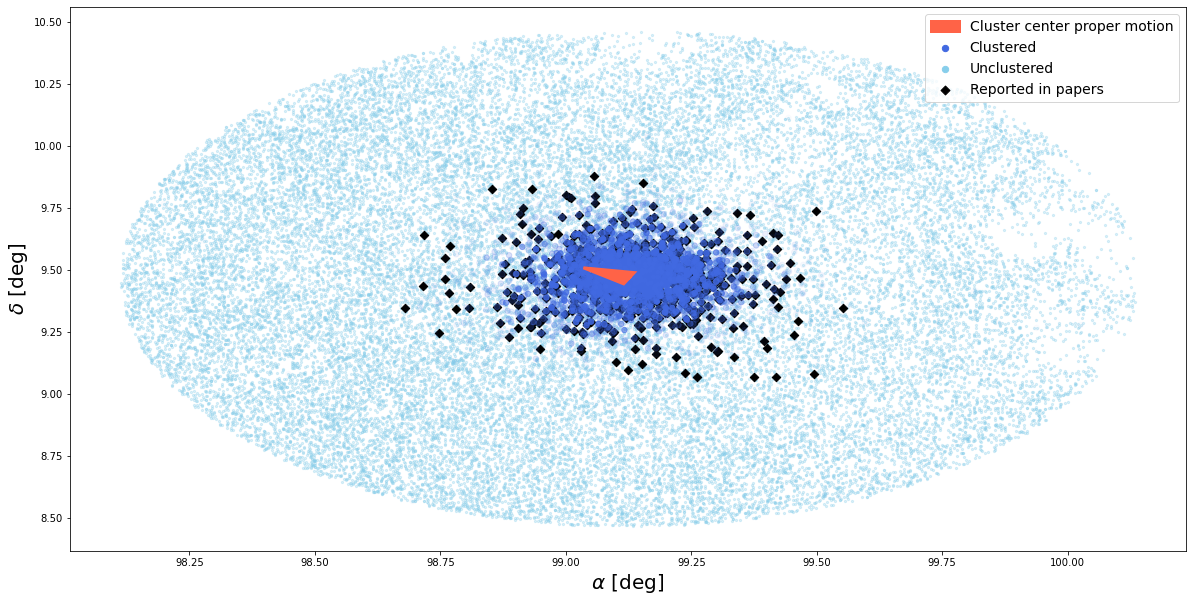

In [19]:
plt.figure(figsize=(20, 10))
plt.scatter(clustered.ra, clustered.dec, 
            color='royalblue', alpha=clustered.occurences, label='Clustered', zorder=2, s=30.)
plt.scatter(noise.ra, noise.dec, color='skyblue', label='Unclustered', zorder=1, s=5., alpha=.3)
plt.scatter(lit_dr3.ra, lit_dr3.dec, color='black', zorder=1,
            marker='D', label='Reported in papers')

plt.gca().set_xlabel('$\\alpha$ [deg]', fontsize=20);
plt.gca().set_ylabel('$\delta$ [deg]', fontsize=20);


plt.arrow(cp_ra,
          cp_dec,
          cp_pmra*(u.arcsec/u.year).to(u.deg/u.year),
          cp_pmdec*(u.arcsec/u.year).to(u.deg/u.year),
          linewidth=3.,
          color='tomato',
          head_width=0.05,
          head_length=0.1,
          zorder=4, label='Cluster center proper motion')

lgnd = plt.legend(fontsize=14, loc='upper right');
for handle in lgnd.legendHandles:
    handle._sizes = [40];
    handle._alpha = 1.;

In [20]:
clustered.to_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_clustered.csv')
found.to_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_found.csv')
not_found.to_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_not_found.csv')

# Convergent velocities

In [13]:
with open(f'optuna_db/{CLUSTER_NAME}/{CLUSTER_NAME.replace(" ", "_")}_cp_best_params.json', 'r') as f:
    best_params = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'optuna_db/NGC 188/NGC_188_cp_best_params.json'

In [ ]:
best_params

In [28]:
clustered, noise, found, not_found = run_dbscan(normalized_cp, gaiadr3, lit_dr3, 0.025, 25, False)

Classified into 51 labels.
Clustered: 724/957
724/957 sources from literature clustered
1384 clustered sources.


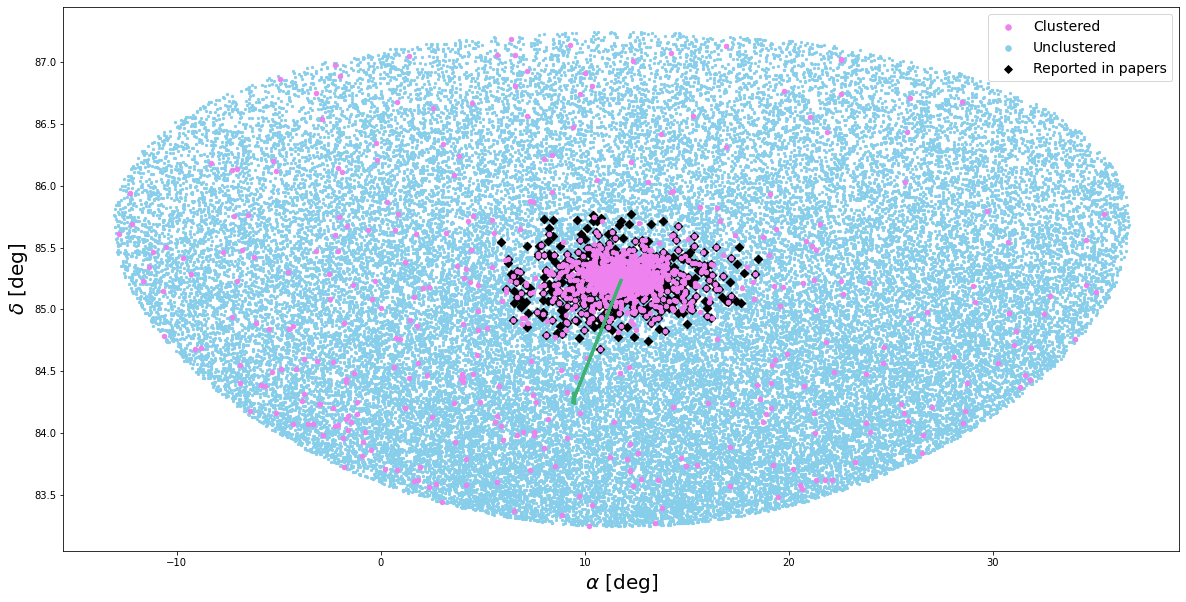

In [29]:
cluster_plot(clustered, gaiadr3, lit_dr3)
plt.arrow(cp_ra,
          cp_dec,
          cp_pmra,
          cp_pmdec,
          linewidth=3.,
          color='mediumseagreen',
          head_width=0.1,
          head_length=0.1,
          zorder=4)

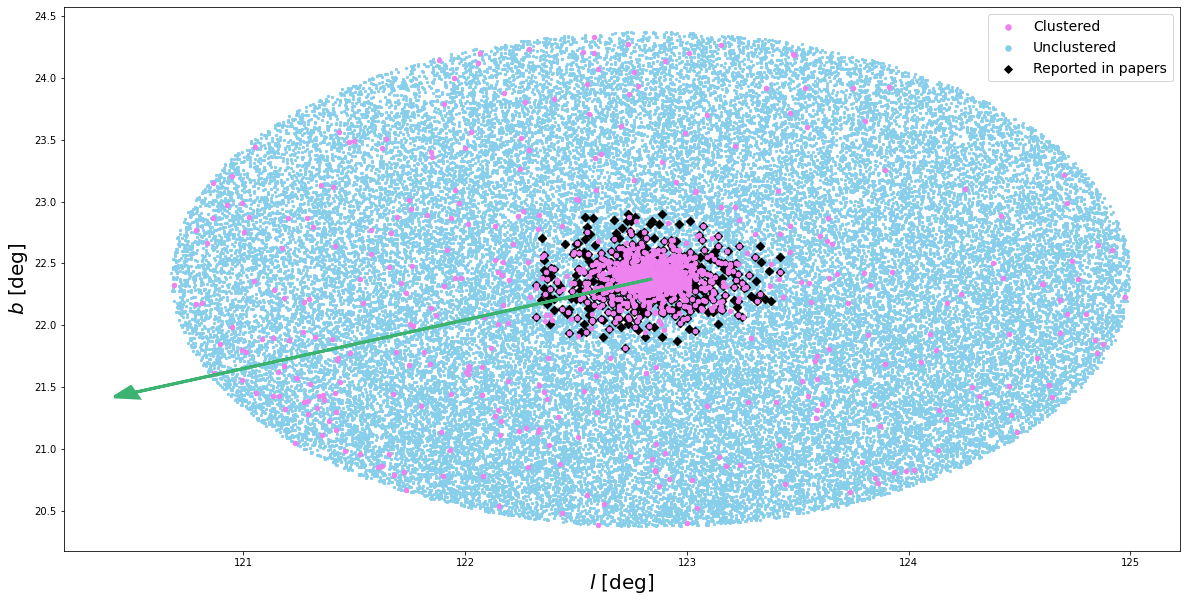

In [30]:
cluster_plot_galactic(clustered, gaiadr3, lit_dr3)
plt.arrow(galactic_coords.l.value,
          galactic_coords.b.value,
          galactic_coords.pm_l_cosb.value,
          galactic_coords.pm_b.value,
          linewidth=3.,
          color='mediumseagreen',
          head_width=0.1,
          head_length=0.1,
          zorder=4)

In [ ]:
a = np.loadtxt('Trumpler 5_isochrone.dat', usecols=(28, 29, 30))

In [ ]:
plt.plot(a[:-1, 1]-a[:-1, 2], a[:-1, 0])
plt.gca().invert_yaxis();